In [10]:
import torch
import torchvision
import torchvision.datasets as datasets # For importing dataset
import torch.utils.data as data

In [11]:
model = torch.jit.load('model_scripted_2.pt')
model.eval()

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=B

In [12]:
from PIL import Image, ImageEnhance
# transform class to make images sharper
class Sharpie(object):
    def __init__(self,factor):
        self.factor = factor

    def __call__(self, x):
        enhancer = ImageEnhance.Sharpness(x)
        img = enhancer.enhance(self.factor)
        return img

In [13]:
# Image preprocessing
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = 2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Device to send data and model to
dataset = datasets.ImageFolder('tests', transform=preprocess)
print(len(dataset))
test_loader = data.DataLoader(dataset, shuffle=False)
print(len(test_loader))

35
35


In [15]:
preds = []
targets = []

with torch.no_grad():
    for batch, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        pred = outputs.argmax(dim=1, keepdim=False)
        for p in pred:
            preds.append(int(p))
        for l in labels:
            targets.append(int(l))
torch.as_tensor(preds) 
torch.as_tensor(targets)

print(preds)
print(targets)

[3, 6, 0, 1, 3, 2, 3, 1, 3, 6, 0, 2, 2, 3, 6, 4, 3, 1, 3, 0, 4, 3, 0, 4, 4, 5, 4, 5, 5, 6, 0, 4, 4, 6, 3]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6]


C:\Users\aymen\AppData\Local\Temp\ipykernel_22928\1456397616.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = plt.subplots(figsize = (1, 3))


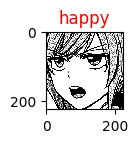

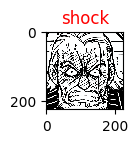

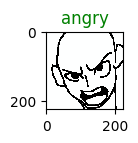

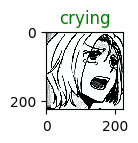

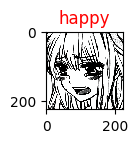

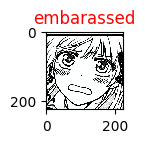

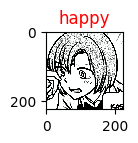

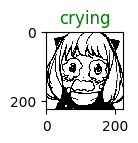

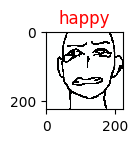

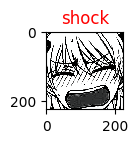

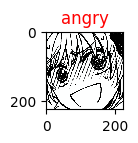

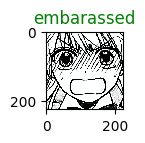

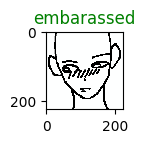

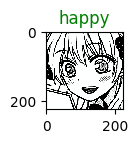

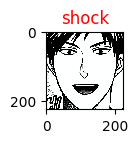

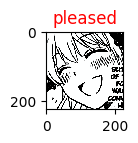

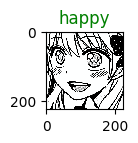

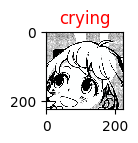

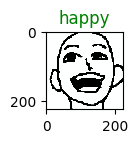

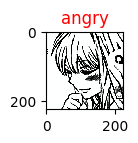

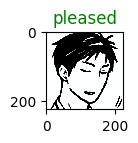

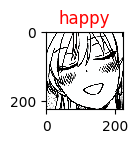

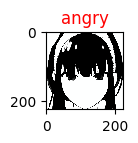

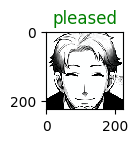

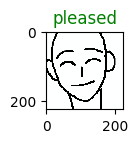

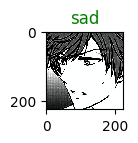

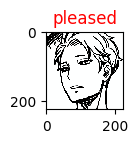

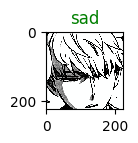

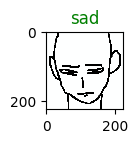

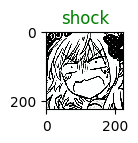

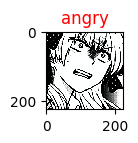

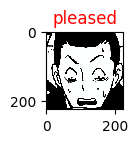

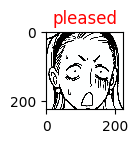

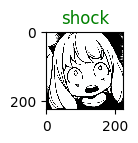

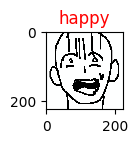

In [16]:
# Display the images (for preprocessing)
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Func
import numpy as np

def show(imgs, pred, act):
  ax = plt.subplots(figsize = (1, 3))
  color = 'green' if pred == act else 'red'
  plt.title(pred, color=color)
  inp = imgs.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp, interpolation='nearest')

idx_to_class = {v: k for k, v in test_loader.dataset.class_to_idx.items()}
display_moods = []
for i, labels in enumerate(preds):
  display_moods.append(idx_to_class[int(labels)])
# print(display_moods)
for i, (inputs, labels) in enumerate(test_loader):
  grid = make_grid(inputs)
  show(grid, display_moods[i], idx_to_class[int(labels)])
# grid = make_grid(ins)
# show(grid)

In [17]:
from torchmetrics import ConfusionMatrix
confmat = ConfusionMatrix(num_classes=7)
confmat(torch.as_tensor(preds), torch.as_tensor(targets))

tensor([[1, 0, 0, 1, 0, 0, 1],
        [0, 2, 1, 3, 0, 0, 0],
        [1, 0, 2, 0, 0, 0, 1],
        [0, 1, 0, 3, 1, 0, 1],
        [2, 0, 0, 1, 3, 0, 0],
        [0, 0, 0, 0, 1, 3, 0],
        [1, 0, 0, 1, 2, 0, 2]])

In [20]:
from torchmetrics.functional import precision_recall
precision_recall(torch.as_tensor(preds), torch.as_tensor(targets), average='micro', num_classes=7)

(tensor(0.4571), tensor(0.4571))